Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [1]:
!pip install category_encoders==2.*
!pip install pdpbox

     |████████████████████████████████| 102kB 2.3MB/s 
     |████████████████████████████████| 57.7MB 528kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=719681c7198ddc7aebef24727f885e5f200d69cbc5a3ecf49cd7a42e0e4ac008
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


Genre            0
ESRB_Rating      0
Platform         0
Publisher        0
Developer        0
Total_Shipped    0
Global_Sales     0
Year             0
dtype: int64
Columns: ['Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Developer', 'Total_Shipped', 'Global_Sales', 'Year']
Baseline Accuracy: 0.7862559844087615
Validation Accuracy: 0.997134737161456
Test Accuracy: 0.998747537283265


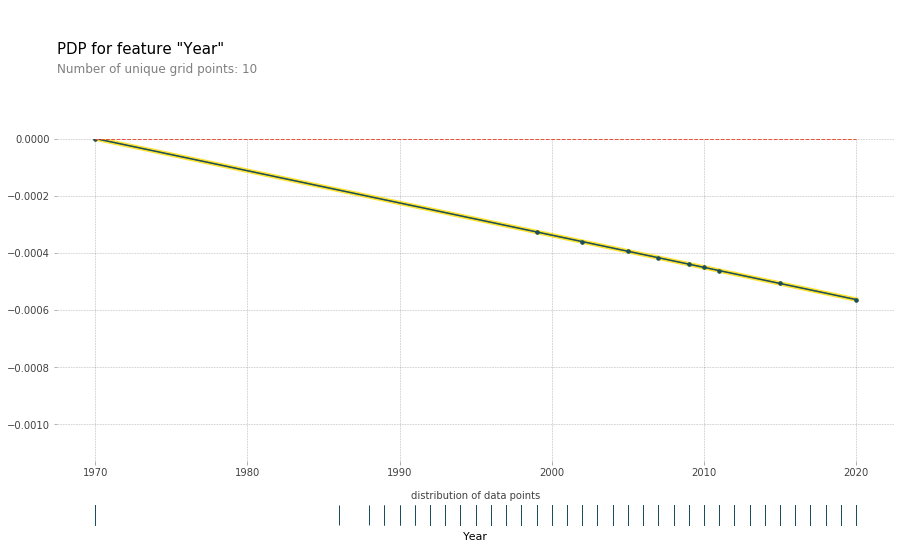

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt

data = pd.read_csv("https://raw.githubusercontent.com/apathyhill/DS-Unit-2-Applied-Modeling/master/data/portfolio/vgsales-12-4-2019.csv")
data2 = data.copy()
#data2["score"] = data2[["VGChartz_Score", "Critic_Score", "User_Score"]].mean(axis=1)

features_excluded = ["Last_Update", "url", "status", "Vgchartzscore", "img_url", "basename", 
                     "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales", "Rank", "Name", 
                     "VGChartz_Score", "Critic_Score", "User_Score"]

data2 = data2.drop(features_excluded, axis=1)

data2["Year"] = data2["Year"].fillna(data2["Year"].median())
data2["Total_Shipped"] = data2["Total_Shipped"].fillna(method="ffill")
data2["Global_Sales"] = data2["Global_Sales"].fillna(method="ffill")
data2 = data2.dropna()

print(data2.isna().sum())
print("Columns:", list(data2.columns))
target = "Global_Sales"

train, test = train_test_split(data2, train_size=0.90)
train, val = train_test_split(train, train_size=0.75)

"""
This is a regression problem, as I am trying to output a continous number.

Simple accuracy could work as a eval matric right now, but I might change it to mean absolue/squared error to see if I can decipher things better.
"""

features_excluded = ["Last_Update", "url", "status", "Vgchartzscore", "img_url", "basename", 
                     "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales", "Rank", "Name", 
                     "VGChartz_Score", "Critic_Score", "User_Score", "ESRB_Rating"]
"""
These last columns are only for information about the game on the VGChartz website, such as cover images, and the url to the game. Not important here.
"basename" is a web-safe, simplified name of the game. (Wii Sports becomes wii-sports)
"NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales" are just  "Global_Sales" split into regions; probably not necessary.
"Rank" is not needed, as it is functionally just an index.
Each entry is a new game with its own title, so the "Name" category is *very* high cardinality, too much to use.


This leaves Genre, ESRB Rating (in seperate columns), Platform, Plublisher, Developer, and Year
"""


#data2[target].plot(kind="hist", bins=50, figsize=(20, 10));

mean = data2[target].mean()
print("Baseline Accuracy:", len(data2[data2[target] < mean])/ len(data2[target]) ) # Baseline is 178,000 sales for 82% accuracy


X_train = train[train.columns.drop(target)]
y_train = train[target]

X_val = val[val.columns.drop(target)]
y_val = val[target]

X_test = test[val.columns.drop(target)]
y_test = test[target]


from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
import numpy as np

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy="median", missing_values=np.nan), 
    Ridge()
)


pipeline.fit(X_train, y_train)
print("Validation Accuracy:", pipeline.score(X_val, y_val))
print("Test Accuracy:", pipeline.score(X_test, y_test))

from pdpbox.pdp import pdp_isolate, pdp_plot
feature = "Year"
f = list(data2[feature].unique())

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(pdp_isolate_out=isolated, feature_name=feature, plot_lines=True, frac_to_plot=100, plot_pts_dist=True);

